## Import

In [1]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

from tqdm import tqdm

## Fixed Random Seed

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

## Data Load

In [781]:
def train_test_split(df, th):
    train = df[df['일시'].str[:8].astype(int) < th].reset_index(drop=True)
    test = df[df['일시'].str[:8].astype(int) >= th].reset_index(drop=True)
    return train, test

In [782]:
train = pd.read_csv('./data/train.csv')

In [783]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [784]:
train_df, test_df = train_test_split(train_df, 20220820)

In [785]:
train_y = train_df['전력소비량(kWh)']
test_y = test_df['전력소비량(kWh)']

In [786]:
building_id_mapper = {}

In [787]:
kWh_order = train_df.groupby('건물번호').mean()['전력소비량(kWh)'].values
for i in range(100):
    building_id_mapper[i+1] = kWh_order[i]

In [788]:
train_df = train_df.replace({'건물번호': building_id_mapper})

In [789]:
test_df = test_df.replace({'건물번호': building_id_mapper})

In [790]:
train['일시']

0         20220601 00
1         20220601 01
2         20220601 02
3         20220601 03
4         20220601 04
             ...     
203995    20220824 19
203996    20220824 20
203997    20220824 21
203998    20220824 22
203999    20220824 23
Name: 일시, Length: 204000, dtype: object

## Train Data Pre-processing

In [791]:
def preprocessing(df, is_test=False):
    columns = ['기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', 'month', 'day', 'time']
#     columns = ['건물번호', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일시']
    # 일조, 일사 열 제거
    unused_columns = ['일조(hr)','일사(MJ/m2)']
    for uc in unused_columns:
        if uc in df.columns:
            df = df.drop(columns=[uc])
    print("===== 결측치")
    print(df.isna().sum())

    # 강수량 결측치 0.0으로 채우기
    df['강수량(mm)'].fillna(0.0, inplace=True)

    # 풍속, 습도 결측치 평균으로 채우고 반올림하기
    df['풍속(m/s)'].fillna(round(df['풍속(m/s)'].mean(),2), inplace=True)
    df['습도(%)'].fillna(round(df['습도(%)'].mean(),2), inplace=True)
    
    df['month'] = df['일시'].apply(lambda x : float(x[4:6]))
    df['day'] = df['일시'].apply(lambda x : float(x[6:8]))
    df['time'] = df['일시'].apply(lambda x : float(x[9:11]))
    
#     df['일시'] = df['일시'].str.replace(' ', '').astype(int)
    if is_test:
        df['전력소비량(kWh)'] = 0
    df = df[columns].reset_index(drop=True)
    return df

In [792]:
window_size = 12 # 예측에 사용될 시간 윈도우 크기

In [793]:
train_df = preprocessing(train_df)

===== 결측치
num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          150066
풍속(m/s)              19
습도(%)                 9
전력소비량(kWh)            0
dtype: int64


In [794]:
train_y_log = np.log(train_y+1)

In [795]:
test_df = preprocessing(test_df, is_test=True)

===== 결측치
num_date_time        0
건물번호                 0
일시                   0
기온(C)                0
강수량(mm)          10003
풍속(m/s)              0
습도(%)                0
전력소비량(kWh)           0
dtype: int64


In [796]:
# test_df = pd.concat([train_df[204000-window_size:], test_df], axis=0).reset_index(drop=True)

## Hyperparameter Setting

In [797]:
# 하이퍼파라미터
input_size = 7  # feature의 개수
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 5
batch_size = 64
learning_rate = 0.001

## Dataset

In [798]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, y, window_size):
        self.df = df
        self.y = y
        self.window_size = window_size

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = torch.tensor(self.df[idx:idx+self.window_size, :], dtype=torch.float)
        if self.df.shape[1] > 1:
#             y = torch.tensor(self.df[idx+self.window_size, -1], dtype=torch.float)
            y = torch.tensor(self.y[idx+self.window_size], dtype=torch.float)
        else:
            y = None
        return x, y

def create_data_loader(df, y, window_size, batch_size):
    dataset = TimeSeriesDataset(df, y, window_size)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader

In [799]:
test_df

,기온(C),강수량(mm),풍속(m/s),습도(%),month,day,time
0,26.8,0.2,2.8,95.0,8.0,20.0,0.0
1,26.6,0.0,2.8,95.0,8.0,20.0,1.0
2,26.3,0.0,3.2,95.0,8.0,20.0,2.0
3,26.2,0.0,2.4,95.0,8.0,20.0,3.0
4,26.0,0.0,2.4,95.0,8.0,20.0,4.0
...,...,...,...,...,...,...,...
11995,23.1,0.0,0.9,86.0,8.0,24.0,19.0
11996,22.4,0.0,1.3,86.0,8.0,24.0,20.0
11997,21.3,0.0,1.0,92.0,8.0,24.0,21.0
11998,21.0,0.0,0.3,94.0,8.0,24.0,22.0


In [800]:
train_df

,기온(C),강수량(mm),풍속(m/s),습도(%),month,day,time
0,18.6,0.0,0.9,42.0,6.0,1.0,0.0
1,18.0,0.0,1.1,45.0,6.0,1.0,1.0
2,17.7,0.0,1.5,45.0,6.0,1.0,2.0
3,16.7,0.0,1.4,48.0,6.0,1.0,3.0
4,18.4,0.0,2.8,43.0,6.0,1.0,4.0
...,...,...,...,...,...,...,...
191995,28.1,0.0,1.9,85.0,8.0,19.0,19.0
191996,27.7,0.0,1.8,87.0,8.0,19.0,20.0
191997,27.7,0.0,1.4,87.0,8.0,19.0,21.0
191998,27.7,0.0,2.4,86.0,8.0,19.0,22.0


In [801]:
# normalization
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_df.values)

In [802]:
# train_data = np.concatenate([train_df.iloc[:, 0].values.reshape(-1, 1), train_data], axis=1)

In [803]:
# train_loader = create_data_loader(train_data, train_y, window_size, batch_size)
train_loader = create_data_loader(train_data, train_y, window_size, batch_size)

In [804]:
test_data = scaler.transform(test_df.values) # train과 동일하게 scaling

In [805]:
# test_data = np.concatenate([test_df.iloc[:, 0].values.reshape(-1, 1), test_data], axis=1)

In [806]:
# Dataset & DataLoader
test_dataset = TimeSeriesDataset(test_data, test_y, window_size)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Model Define

In [807]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 48)
        self.fc2 = nn.Linear(48, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = torch.nn.functional.gelu(out)
        out = self.fc2(out)

        return out

In [808]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"current device: {device}")

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

current device: cpu


## Train

In [809]:
for epoch in range(3):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 300 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/5], Step [300/3000], Loss: 2669.4355
Epoch [1/5], Step [600/3000], Loss: 1649.9869
Epoch [1/5], Step [900/3000], Loss: 1513.7834
Epoch [1/5], Step [1200/3000], Loss: 1067.0603
Epoch [1/5], Step [1500/3000], Loss: 1482.5178
Epoch [1/5], Step [1800/3000], Loss: 1130.9070
Epoch [1/5], Step [2100/3000], Loss: 1406.8228
Epoch [1/5], Step [2400/3000], Loss: 1587.7223
Epoch [1/5], Step [2700/3000], Loss: 999.4359
Epoch [1/5], Step [3000/3000], Loss: 1375.3641
Epoch [2/5], Step [300/3000], Loss: 1403.7498
Epoch [2/5], Step [600/3000], Loss: 1120.5962
Epoch [2/5], Step [900/3000], Loss: 1192.0476
Epoch [2/5], Step [1200/3000], Loss: 1230.7208
Epoch [2/5], Step [1500/3000], Loss: 1131.4420
Epoch [2/5], Step [1800/3000], Loss: 1410.0828
Epoch [2/5], Step [2100/3000], Loss: 1354.4412
Epoch [2/5], Step [2400/3000], Loss: 1024.1580
Epoch [2/5], Step [2700/3000], Loss: 993.8912
Epoch [2/5], Step [3000/3000], Loss: 1384.0103
Epoch [3/5], Step [300/3000], Loss: 1277.7648
Epoch [3/5], Step [600

<Axes: >

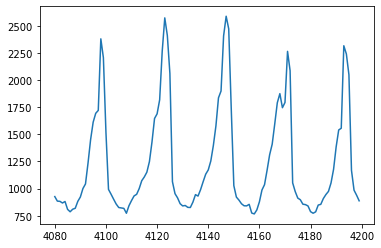

In [819]:
train[train['건물번호'] == 3]['전력소비량(kWh)'][:120].plot()

<Axes: >

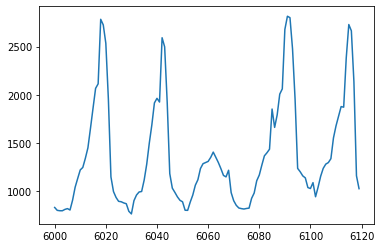

In [820]:
train[train['건물번호'] == 3]['전력소비량(kWh)'][-120:].plot()

In [821]:
train

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


## Inference

In [772]:
model.eval()

test_predictions = []
xes = []
with torch.no_grad():
    for i in range(test_data.shape[0] - window_size):
        x = torch.Tensor(test_data[i:i+window_size,:]).to(device)
        new_x = model(x.view(1,window_size,-1))
#         xes.append(new_x)
#         test_data[i+window_size,-1] = new_x # 입력 업데이트
        test_predictions.append(new_x.detach().cpu().numpy().item()) # 예측 결과 저장

## Validate

In [773]:
def SMAPE(y, pred):
    smape = abs((y - pred))/((abs(y) + abs(pred)) / 2) * 100
    smape = np.mean(smape)
    return smape

def mae(y, pred):
    return np.mean(abs(y-pred))

In [774]:
# pred = scaler.inverse_transform(test_data)[window_size:,-1] # 원래 scale로 복구

In [775]:
pred = np.array(test_predictions)

In [776]:
y = test_y.values[window_size:]

In [777]:
pd.DataFrame({'y':y, 'pred': pred}).sample(10)

,y,pred
5710,2571.48,1302.590332
4934,364.68,1383.057373
9402,2405.76,2041.299194
3160,14756.00,8967.192383
9962,1822.56,1831.850952
9822,2694.24,2078.967041
4472,2281.32,1661.502441
6460,3161.52,1862.408691
5293,2593.44,2188.164795
10310,880.56,841.478638


<Axes: >

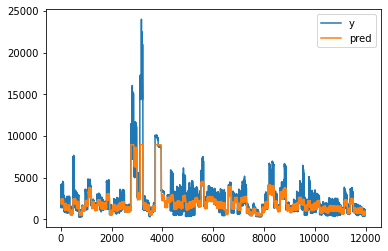

In [778]:
pd.DataFrame({'y':y, 'pred': pred}).plot()

In [779]:
SMAPE(y, pred)

34.39549032708791

In [780]:
mae(y, pred)

790.0377546172066

## Submit

In [19]:
predictions = scaler.inverse_transform(test_data)[24:,-1] # 원래 scale로 복구

In [20]:
sample_submission['answer'] = predictions
sample_submission.head()

,num_date_time,answer
0,1_20220825 00,492.777998
1,1_20220825 01,508.540358
2,1_20220825 02,507.235912
3,1_20220825 03,520.526870
4,1_20220825 04,579.702946


In [ ]:
sample_submission.to_csv('lstm_baseline_submission.csv', index=False)